In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# EDA

In [2]:
# Kiểm tra dữ liệu đầu vào
print(os.listdir("../input"))

# Đọc dữ liệu
data = pd.read_json('../input/introduction-to-machine-learning-project-cq-24-2/train.json')
data['length_of_embedding'] = data.audio_embedding.apply(len)
data.head()

['introduction-to-machine-learning-project-cq-24-2']


,audio_embedding,is_turkey,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip,length_of_embedding
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",0,kDCk3hLIVXo,70,60,10
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",1,DPcGzqHoo7Y,40,30,10
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",1,7yM63MTHh5k,240,230,10
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",1,luG3RmUAxxM,520,510,10
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",0,PIm3cjxTpOk,10,0,10


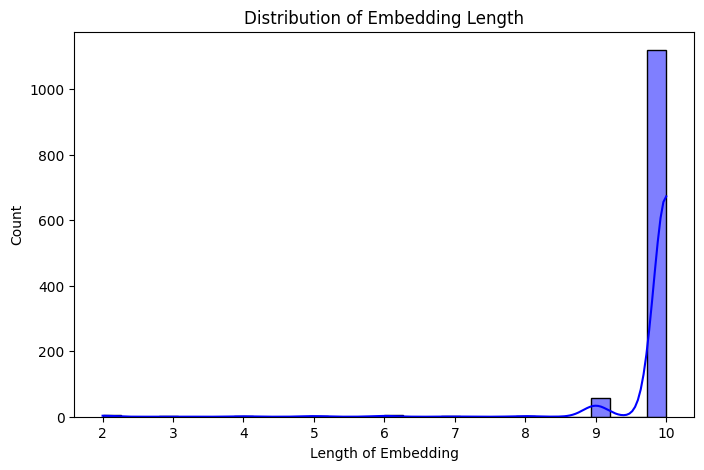

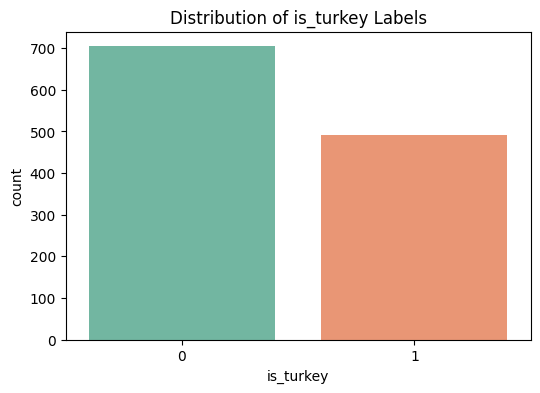

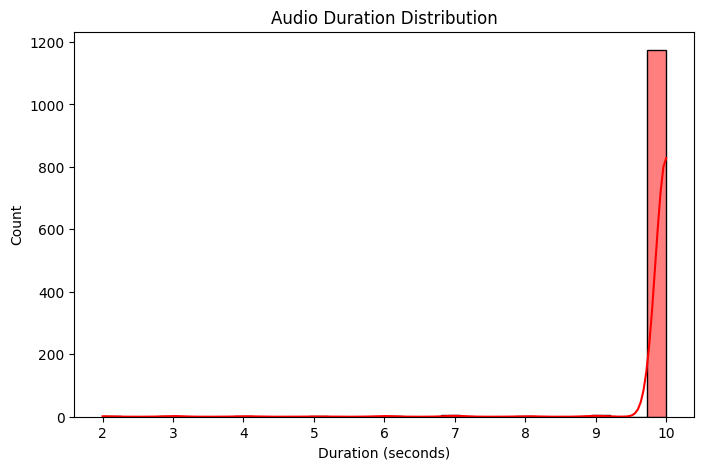

,audio_embedding,is_turkey,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip,length_of_embedding,duration
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",0,kDCk3hLIVXo,70,60,10,10
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",1,DPcGzqHoo7Y,40,30,10,10
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",1,7yM63MTHh5k,240,230,10,10
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",1,luG3RmUAxxM,520,510,10,10
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",0,PIm3cjxTpOk,10,0,10,10


In [3]:
# ==================== Trực quan dữ liệu ====================

# Trực quan độ dài embedding
plt.figure(figsize=(8, 5))
sns.histplot(data['length_of_embedding'], kde=True, bins=30, color='blue')
plt.title('Distribution of Embedding Length')
plt.xlabel('Length of Embedding')
plt.show()

# Trực quan biến mục tiêu is_turkey
plt.figure(figsize=(6, 4))
sns.countplot(x='is_turkey', data=data, palette='Set2')
plt.title('Distribution of is_turkey Labels')
plt.show()

# Trực quan thời lượng audio
data['duration'] = data.end_time_seconds_youtube_clip - data.start_time_seconds_youtube_clip

plt.figure(figsize=(8, 5))
sns.histplot(data['duration'], bins=30, kde=True, color='red')
plt.title('Audio Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.show()

data.head()

In [4]:
# ==================== Xử lý dữ liệu ====================

def create_df(data, i):
    df = pd.DataFrame(data.audio_embedding.iloc[i])
    df['is_turkey'] = data.is_turkey.iloc[i]
    return df

# Tạo danh sách các DataFrame từ mỗi audio_embedding
vid_df = [create_df(data, i) for i in range(len(data))]

# Gộp tất cả thành một DataFrame duy nhất
data_flatten = pd.concat(vid_df, ignore_index=True)

# Đặt tên cho các cột đặc trưng
data_flatten.columns = ['feature_' + str(i) for i in range(128)] + ['is_turkey']

# Tách tập đặc trưng (X) và nhãn (y)
X = data_flatten.iloc[:, :128]
y = data_flatten['is_turkey']

# ==================== In ra dữ liệu sau xử lý ====================

print("Shape of feature matrix X:", X.shape)
print("Shape of label vector y:", y.shape)

combined_df = pd.concat([X, y], axis=1)
combined_df.head()



Shape of feature matrix X: (11795, 128)
Shape of label vector y: (11795,)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,is_turkey
0,172,34,216,110,208,46,95,66,161,125,...,0,1,170,0,8,255,129,4,255,0
1,171,39,199,121,238,62,59,61,170,146,...,70,0,237,0,49,255,126,188,255,0
2,169,33,200,97,210,22,73,51,169,129,...,48,106,207,0,39,234,205,33,255,0
3,180,39,218,118,213,73,80,43,160,147,...,117,35,137,0,58,255,103,153,255,0
4,166,31,204,134,211,59,62,73,187,167,...,0,0,219,0,152,255,58,177,255,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Development

In [6]:
# ==================== Huấn luyện với các models ====================

models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

results = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    results[name] = (fpr, tpr, roc_auc)
    trained_models[name] = deepcopy(model)  # Lưu lại model đã train

[LightGBM] [Info] Number of positive: 3851, number of negative: 5585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29679
[LightGBM] [Info] Number of data points in the train set: 9436, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408118 -> initscore=-0.371752
[LightGBM] [Info] Start training from score -0.371752


# Model Evaluation

Best model from step 1: XGBoost (AUC = 0.972)


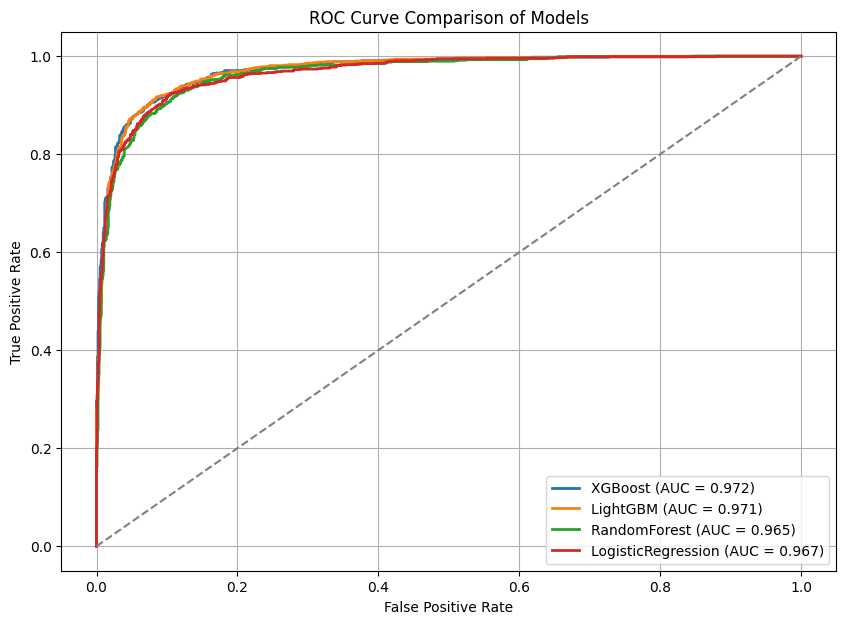

In [7]:
# Đánh giá bước 1

# Chọn model tốt nhất từ bước 1
best_model_name = max(results, key=lambda x: results[x][2])
best_model_auc = results[best_model_name][2]
print(f"Best model from step 1: {best_model_name} (AUC = {best_model_auc:.3f})")

# Vẽ ROC Curve
plt.figure(figsize=(10, 7))

for name, (fpr, tpr, roc_auc) in results.items():
    plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.3f)' % (name, roc_auc))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Models')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Best model: XGBoost
New ROC AUC for improved XGBoost: 0.971
Original model is better. Reverting to step 1 model.


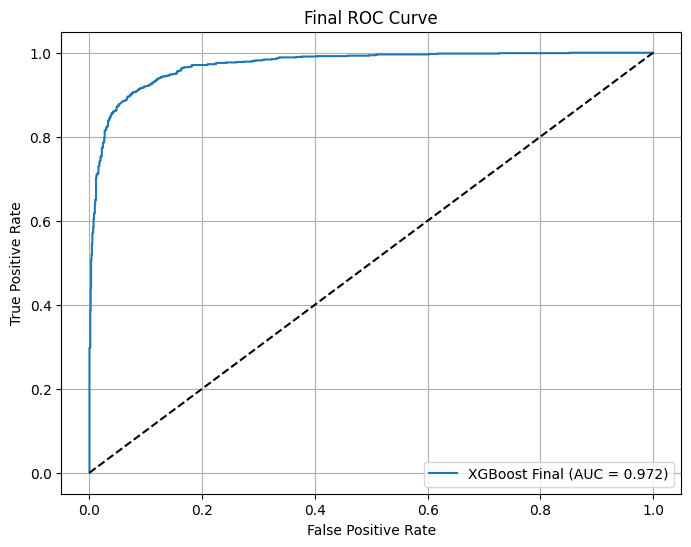

In [8]:
# Đánh giá bước 2

# 1. Chọn model tốt nhất
best_model_name = max(results, key=lambda x: results[x][2])
print(f"Best model: {best_model_name}")

# 2. Khởi tạo model với tham số cải tiến
if best_model_name == "RandomForest":
    improved_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
elif best_model_name == "XGBoost":
    import xgboost as xgb
    improved_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
elif best_model_name == "LogisticRegression":
    from sklearn.linear_model import LogisticRegression
    improved_model = LogisticRegression(C=0.5, max_iter=200, solver='lbfgs', random_state=42)
else:
    raise ValueError("Model không được hỗ trợ")

# 3. Train lại
improved_model.fit(X_train, y_train)

# 4. Đánh giá lại model
y_scores = improved_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
new_roc_auc = auc(fpr, tpr)
print(f"New ROC AUC for improved {best_model_name}: {new_roc_auc:.3f}")

# 5. So sánh và chọn model cuối cùng
if new_roc_auc > best_model_auc:
    final_model = improved_model
    final_auc = new_roc_auc
    print("Improved model is better. Using improved version.")
else:
    final_model = trained_models[best_model_name]
    final_auc = best_model_auc
    fpr, tpr, _ = results[best_model_name]
    print("Original model is better. Reverting to step 1 model.")

# 6. Vẽ ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'{best_model_name} Final (AUC = {final_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Prediction

In [9]:
# ==================== Dự đoán trên tập test với model tốt nhất ====================

# Dự đoán
data_test = pd.read_json('../input/introduction-to-machine-learning-project-cq-24-2/test.json')

def create_df_test(data, i):
    df = pd.DataFrame(data.audio_embedding.iloc[i])
    df['vid_id'] = data.vid_id.iloc[i]
    return df

vid_df_test = [create_df_test(data_test, i) for i in range(len(data_test))]
data_flatten_test = pd.concat(vid_df_test)

data_flatten_test.columns = ['feature_' + str(i) for i in range(128)] + ['vid_id']
X_submit = data_flatten_test.iloc[:, :128]

y_pred_test = model.predict_proba(X_submit)[:, 1]

# Kết quả
result = pd.concat([data_flatten_test['vid_id'].reset_index(drop=True), pd.Series(y_pred_test, name='is_turkey')], axis=1)
final_result = result.groupby('vid_id').is_turkey.max().reset_index()
final_result.to_csv('22120214_22120389_22120422.csv', index=False)